In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import torch
from torch.utils.data import DataLoader
import os
import numpy as np
from PIL import Image

from utils.loss import LOSS_FN_H, LOSS_EVAL_H
from utils.model import SegDataset, UNet
from utils.utils import load_model, read_raster, read_raster_multi
from utils.embedding import embed_token_raster, load_embedding

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [25]:



device = "cpu"
train_images = ["./data/zurich_mask.tif", "./data/zurich_osm.tif"]
mask_images  = ["./data/zurich.tif"]

train_images = ["./data/sg_mask.tif", "./data/sg_osm.tif"]                     
mask_images  = ["./data/sg.tif"]                                              

train_rasters = []
mask_rasters  = []
for file in train_images:
    if file.endswith('osm.tif'):
        data_rasters, _, _, _ = read_raster_multi(file)
        for data in data_rasters:
            train_rasters.append(torch.tensor(data, device=device, dtype=torch.float32))
    elif file.endswith('zones_tokens.tif'):
        data, _, _, _ = read_raster(file)
        emb2 = load_embedding("afs.bzo_zone_v.emb.pt", device="cpu")
        emb_map2 = embed_token_raster(data, emb2)          # [8, 512, 512]
        for data in emb_map2:
            train_rasters.append(torch.tensor(data, device=device, dtype=torch.float32))
        print(emb_map2.shape)
    else:
        data, _, _, _ = read_raster(file)
        train_rasters.append(torch.tensor(data, device=device, dtype=torch.float32))
for file in mask_images:
    data, _, _, _ = read_raster(file)
    mask_rasters.append(torch.tensor(data, device=device, dtype=torch.float32))
data_shape = data.shape


In [26]:

model = None
prev_losses = None


def loadModelH():
    global prev_losses
    filename = 'models/model_height.100.pth'
    current_epoch = 100
    MODEL_LOADED = None
    if filename is not None:
        loaded = load_model(filename, UNet, strict=True, load_ema=True, in_channels=len(train_rasters))
        model = loaded["model"].to(device)
        prev_losses = loaded["prev_losses"]
        print('Model loaded:', filename)
    return model, current_epoch, MODEL_LOADED

model, _,_ = loadModelH()


Model loaded: models/model_height.100.pth


location: [1153, 6974]
loss: 417.13470458984375 298.9796142578125, diff sum: 1126221.25
eval - MAE:4.296193, MSE: 417.134705


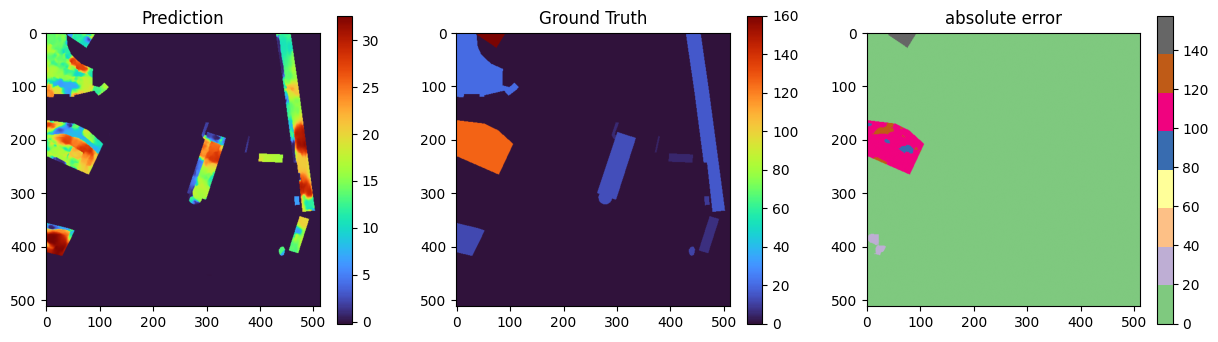

location: [1268, 3354]
loss: 549.5985107421875 298.9796142578125, diff sum: 2385427.25
eval - MAE:9.099685, MSE: 549.598511


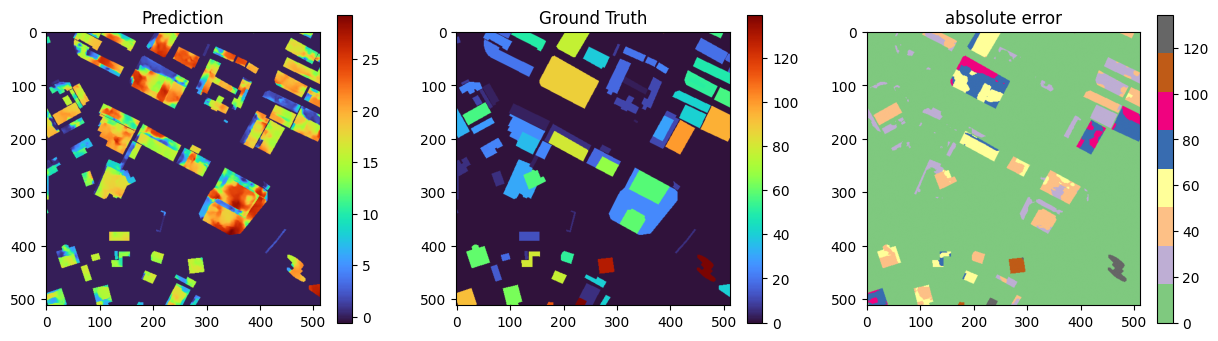

location: [2941, 6939]
loss: 228.94168090820312 298.9796142578125, diff sum: 1418406.0
eval - MAE:5.410790, MSE: 228.941681


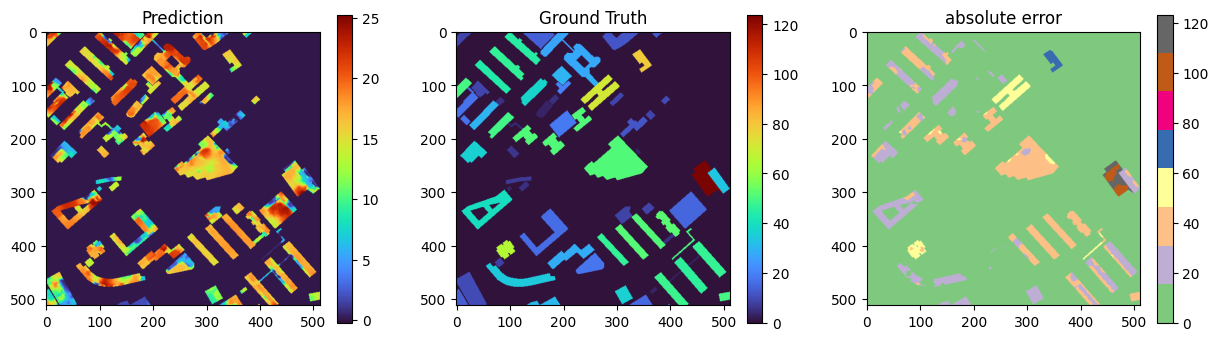

location: [4876, 5998]
loss: 0.2436840534210205 298.9796142578125, diff sum: 9638.9541015625
eval - MAE:0.036770, MSE: 0.243684


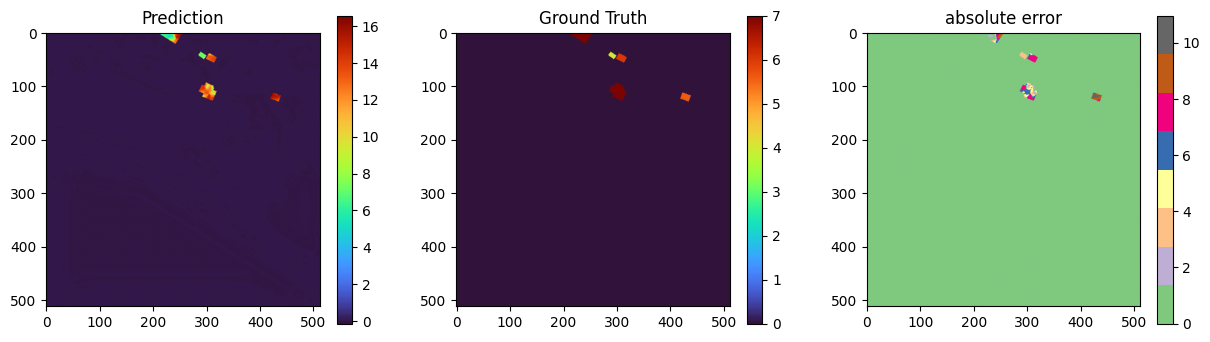

In [27]:


idx = []
datalen = 4
batch_size = 8
scan = 128
size = 512
footprint_raster = train_rasters[0]
while len(idx) < batch_size:
    y, x = random.randint(0, data_shape[0] - 512 - 1), random.randint(0, data_shape[1] - 512 - 1)
    if footprint_raster[y : y+size, x : x+size].sum() > 0:
        idx.append([y, x])
idx = [[1153, 6974], [1268, 3354], [2941, 6939],[4876, 5998]]
dataset = SegDataset(train_rasters, mask_rasters, idx, size=512, offset=[0, 0], terrain_idx=None)
val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model.eval()
with torch.no_grad():
    for step, batch in enumerate(val_loader):
        imgs, masks = batch[0].to(device), batch[1].to(device)
        logits = model(imgs)
        loss = LOSS_FN_H(logits, imgs, masks)
        for j in range(datalen):
            # pred = (logits[j,0] * (1 - imgs[j,0])).clamp(0, 1).cpu().numpy() 
            pred = (logits[j,0]).cpu().numpy() 
            # pred = torch.sigmoid(logits[j,0]).cpu().numpy() 
            true = masks[j,0].cpu().numpy()

            valmin = np.min([pred, true])
            diff = np.abs(pred - true)
            diffmax = np.max(diff)
            val = [{
                'label': 'Prediction',
                'v': pred,
                "color": 'turbo',
                'vminmax': [None, None]
            }, { 
                'label': 'Ground Truth',
                'v': true,
                "color": 'turbo',
                'vminmax': [None, None]
            }, {
                'label': f'absolute error',
                'v': diff,
                "color": 'Accent',
                'vminmax': [0, diffmax]
                # 'vminmax': [0, min(10, diffmax)]
                # 'vminmax': [None, None]
            # }, {
            #     'label': 'mask',
            #     'v': img[0].cpu().numpy()[scan : -scan, scan : -scan],
            #     "color": None,
            #     # 'vminmax': [0, 0.2]
            #     'vminmax': [0, 1]
            }]
            fig, ax = plt.subplots(1, len(val))
            
            fig.set_figheight(4)
            fig.set_figwidth(15)

            for i in range(len(val)):
                vmin, vmax = val[i]['vminmax']
                im = ax[i].imshow(val[i]['v'], val[i]['color'], vmin=vmin, vmax=vmax)
                ax[i].set_title(val[i]['label'])

                plt.colorbar(im)

            lss = LOSS_FN_H(logits[j:j+1], imgs[j:j+1], masks[j:j+1])
            lss_eval = LOSS_EVAL_H(logits[j:j+1], imgs[j:j+1], masks[j:j+1])
            print(f'location: {idx[j]}')
            print(f'loss: {lss} {loss}, diff sum: {diff.sum()}')
            print(f'eval - {lss_eval}')
            plt.show()


train loss [7.837234658785126, 1.9534512758245313, 1.09347999093288, 0.7247601073972045, 0.4981738257989419, 0.3923693735041004, 0.3170472783426812, 0.25696935482553274, 0.23051936694675085, 0.19085645367928572, 0.17272317120991104, 0.16350868666266935, 0.15026620651682848, 0.12897209585996103, 0.12930435917325211, 0.10840256892363762, 0.10390215082356591, 0.09326084719682404, 0.08269366978164083, 0.07661523484671992, 0.07559976536821533, 0.065027788015944, 0.07206307170738879, 0.0665369382880231, 0.057620148409485324, 0.051821607487703834, 0.05262701813063793, 0.05336375972864272, 0.04553983607018099, 0.05172864492367478, 0.04282277427448622, 0.04044833501849608, 0.03739378322721823, 0.0404042139918931, 0.04344724492734481, 0.03440344011191831, 0.036341142211757174, 0.037273736320422815, 0.03348542952986959, 0.03520410700886722, 0.03290537887202715, 0.030437029453663188, 0.032399758219918404, 0.028298287557218003, 0.027162463505885852, 0.02547584373133228, 0.023325948503635487, 0.0289

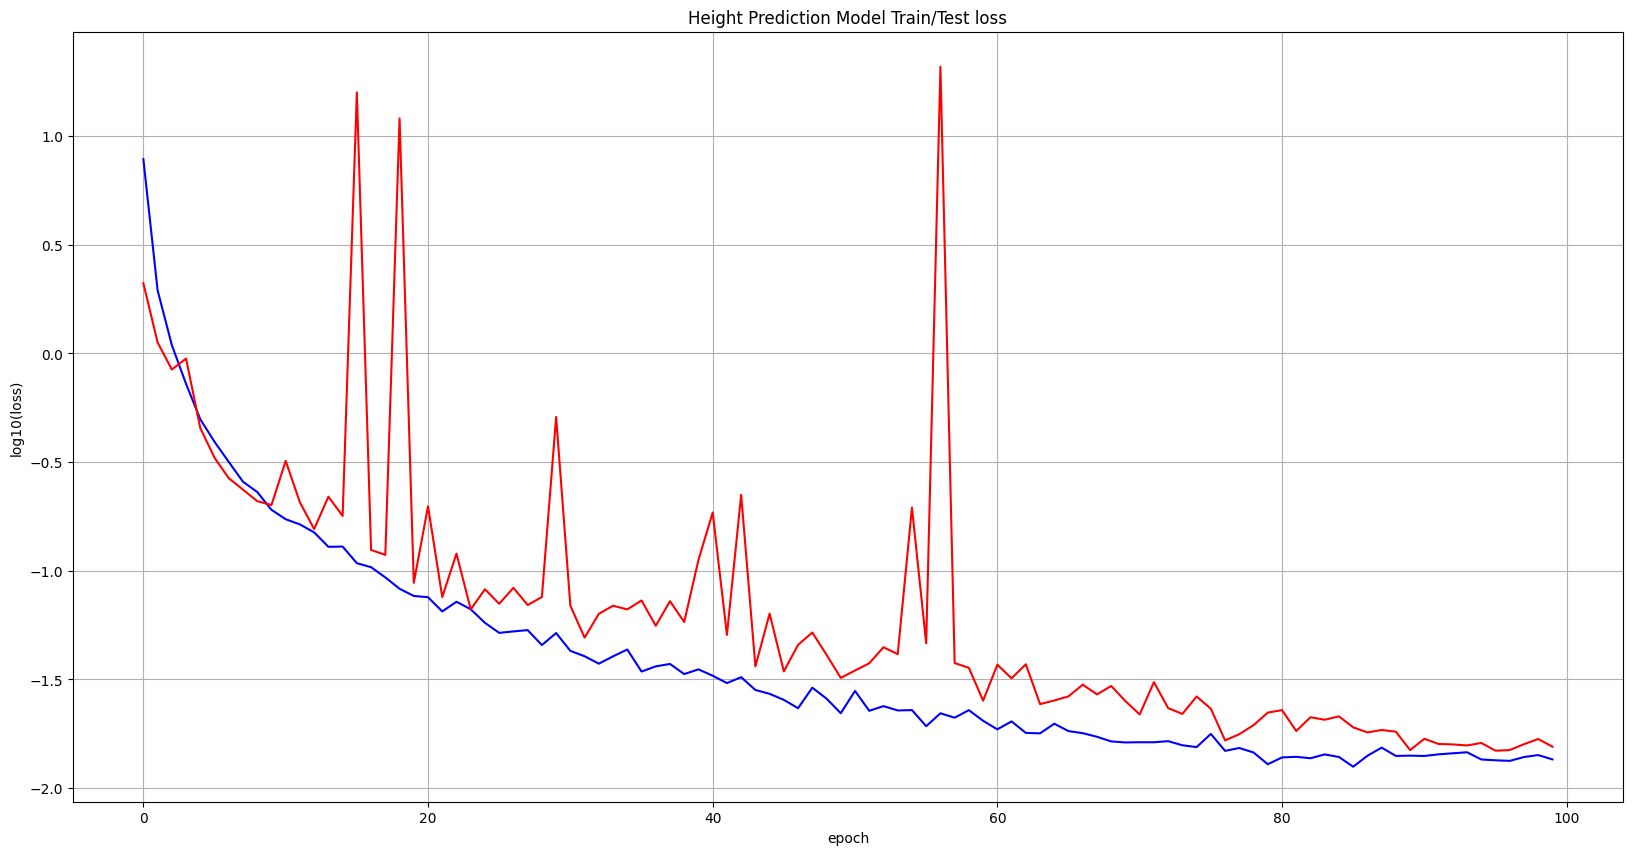

In [28]:

if prev_losses:
    l_t = (prev_losses[0].copy())
    l_v = np.clip(prev_losses[1], 0, 0.5)
    l_v = prev_losses[1].copy()
    print('train loss', l_t)
    print('test lost',l_v)
    l_t_log = np.log10(l_t)
    l_v_log = np.log10(l_v)
    # l_t[0] = None
    # l_v[0] = None
    # print(l_t)
    # print(l_v)

    # plt.plot(l_t, c='b')
    # plt.plot(l_v, c='r')
    # plt.xticks([i for i in range(len(l_v))], [f'{i+1}' for i in range(len(l_v))])
    # plt.xlabel('epoch')
    # plt.ylabel('loss')
    # plt.ylim(0, np.max([l_t[1:], l_v[1:]]) * 1.1)
    # plt.rcParams["figure.figsize"] = (20,3)

    # plt.show()

    plt.plot(l_t_log, c='b')
    plt.plot(l_v_log, c='r')
    # plt.xticks([i for i in range(len(l_v))], [f'{i+1}' for i in range(len(l_v))])
    plt.title('Height Prediction Model Train/Test loss')
    plt.xlabel('epoch')
    plt.ylabel('log10(loss)')
    plt.grid(True)
    # plt.ylim(None, np.max([l_t[1:], l_v[1:]]) * 1.1)
    plt.rcParams["figure.figsize"] = (20,10)

    plt.show()

c:\Users\phuon\miniforge3\Lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


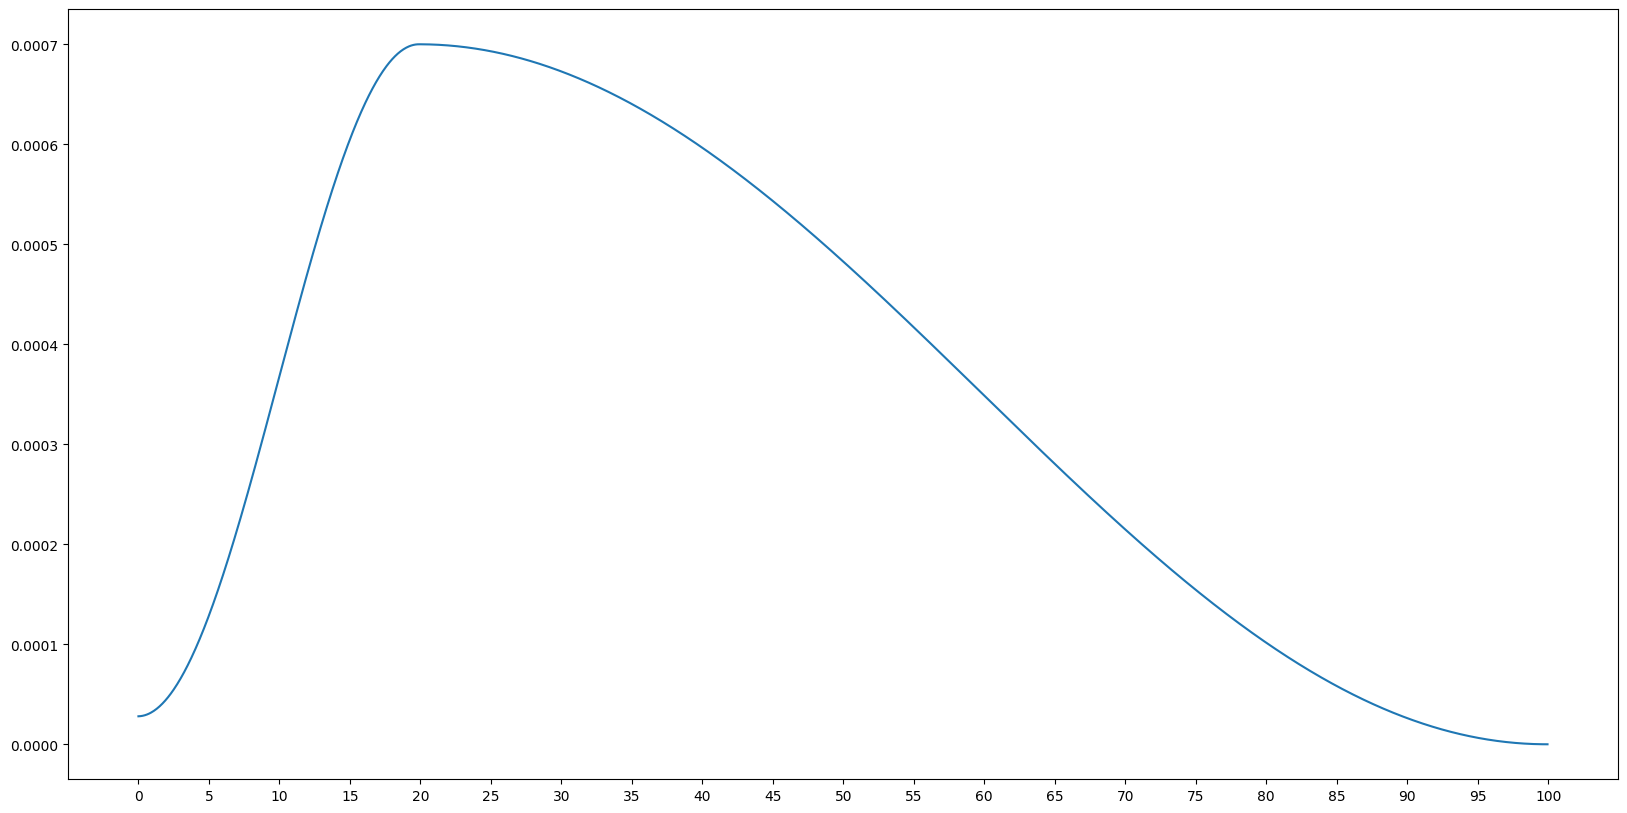

In [30]:
epochs = 100
steps_per_epoch = 20
steps = []
lrs = []
mm = UNet(in_channels=len(train_images), out_channels=len(mask_images), M=32).to(device)
opt = torch.optim.Adam(mm.parameters(), lr=1e-3)

# scheduler = WarmupCosineScheduler(
#     optimizer=opt,
#     warmup_steps=int(steps_per_epoch * epochs / 20),           # number of steps to linearly warm up
#     total_steps=steps_per_epoch * epochs,          # total training steps
#     base_lr=5e-4,
#     final_lr=5e-6
# )

# for epoch in range(epochs):
#     for batch in range(steps_per_epoch):
#         scheduler.step()
#         lrs.append(scheduler.get_last_lr()[0])
#         steps.append(epoch * steps_per_epoch + batch)

# plt.plot(steps, lrs, label='OneCycle')

steps = []
lrs = []
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    opt,
    max_lr  = 7e-4,          # peak LR; scale with batch size
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start = 0.2,         # 30% warmup (anneal up)
    div_factor = 25,         # initial_lr = max_lr/div_factor
    final_div_factor = 1e3,  # min_lr = max_lr/final_div_factor
    anneal_strategy="cos",
    cycle_momentum=False
)
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * steps_per_epoch + batch)

plt.figure(figsize=(20, 10))
plt.plot(steps, lrs, label='OneCycle')
plt.xticks([i * steps_per_epoch for i in range(0, epochs + 1, 5)], [f'{i}' for i in range(0, epochs + 1, 5)])

plt.show()
